# Hebrew Topic Modeling – Data Preparation Notebook

Notebook להכנת הדאטה למחקר:

1. הורדה והכנה של **Emotion UGC** מתוך HeBERT (תגובות גולשים לאתרי חדשות בעברית).
2. הורדה והכנה של **ויקיפדיה בעברית** (דגימה של ערכים כ"מסמכים").
3. שמירה של שני הדאטה־סטים בפורמט נוח (Parquet/CSV) עבור Topic Modeling (LSA/LDA/Top2Vec/C-Top2Vec וכו').

> **הערה:** חלק מהשלבים מורידים קבצים די גדולים (בעיקר ויקיפדיה). רצוי להריץ על Colab עם GPU/TPU או לפחות RAM סביר, ולהקטין כמויות אם צריך.


## תיאור הדאטה (מקור, זמן איסוף, מגבלות, ייצוג)
**מקור:**
- UGC: Emotion UGC מתוך מאגר HeBERT (data.zip).
- Wiki: דמפ ויקיפדיה בעברית (hewiki-latest-pages-articles.xml.bz2).

**זמן איסוף:**
- ויקיפדיה: גרסת `latest` לפי תאריך ההורדה.
- HeBERT: הדאטה כפי שפורסם במאגר (תאריך האיסוף המקורי לא מצוין).

**מגבלות:**
- דגימה וחיתוך ערכים (למשל 100 מילים) כדי לחסוך זיכרון → פגיעה בהקשר.
- UGC כולל סלנג, טעויות כתיב ומסמכים קצרים מאוד.
- הדאטה לא מייצג באופן מלא את כל האוכלוסייה.

**ייצוג אוכלוסייה:**
- Wiki: כתיבה אנציקלופדית של עורכים ותורמים.
- UGC: תגובות גולשים (אוכלוסיית מגיבים, לא מדגם מייצג).

**רישוי ופרטיות:**
- ויקיפדיה תחת CC BY-SA — לשמור ייחוס אם משתפים נגזרות.
- רישוי HeBERT מוגדר במאגר המקורי.
- להימנע משמירת מידע אישי בדוגמאות/דוח.


In [ ]:
!pip install -q pandas tqdm mwparserfromhell lxml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.5/256.5 kB 6.4 MB/s eta 0:00:00


## 1. הגדרות בסיסיות

נגדיר נתיבים ומספרי מסמכים מקסימליים (כדי שלא נקריס את קולאב).


### קלט/פלט לשלב זה
**קלט אפשרי:**
- `data.zip` של HeBERT (Emotion UGC)
- דמפ ויקיפדיה בעברית (`hewiki-latest-pages-articles.xml.bz2`)

**פלט עיקרי (נשמר תחת `data/`):**
- `hebert_ugc_docs.parquet`
- `hebert_ugc_sample_10k.parquet`
- `wiki_hebrew_articles.parquet`
- `wiki_hebrew_sample_5k.parquet`


In [ ]:
import sys
from pathlib import Path

def _add_repo_root():
    cwd = Path.cwd()
    for path in [cwd] + list(cwd.parents):
        if (path / 'project_paths.py').exists():
            sys.path.insert(0, str(path))
            return path
    return cwd

_add_repo_root()

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

from project_paths import get_paths

paths = get_paths().ensure()
BASE_DIR = paths.root
DATA_DIR = paths.data_dir
MODELS_DIR = paths.models_dir
RESULTS_DIR = paths.results_dir
RESULTS_ROOT = RESULTS_DIR

print('BASE_DIR  :', BASE_DIR)
print('DATA_DIR  :', DATA_DIR)
print('MODELS_DIR:', MODELS_DIR)
print('RESULTS_DIR:', RESULTS_DIR)


Mounted at /content/drive


In [ ]:
from pathlib import Path
import os

# כמה מסמכים מקסימום לקחת מכל מקור (אפשר לשנות לפי הצורך)
# MAX_HEBERT_DOCS = 200_000   # תגובות UGC – אפשר להגדיל/להקטין
MAX_WIKI_ARTICLES = 20_000  # ערכי ויקיפדיה – מספיק יופי לטופיק מודלינג

# DATA_DIR, MAX_HEBERT_DOCS, MAX_WIKI_ARTICLES


## 2. הורדה והכנת Emotion UGC מתוך HeBERT

נשתמש ב־`data.zip` מתוך [מאגר HeBERT ב-GitHub](https://github.com/avichaychriqui/HeBERT), שבו נמצאים כל הדאטה־סטים (כולל Emotion UGC).

הרעיון:

1. להוריד את `data.zip` לתיקיית `data/hebert_raw`.
2. לפתוח את ה־ZIP.
3. לטעון את כל קבצי ה־CSV/TSV הרלוונטיים.
4. לזהות עמודת טקסט מתאימה (ננסה לזהות אוטומטית; אם צריך – נשנה ידנית).
5. לבנות DataFrame עם עמודות בסיסיות: `source`, `text`, ואולי שדות נוספים.


In [ ]:
import zipfile
import pandas as pd
from tqdm.auto import tqdm

HEBERT_DATA_DIR = DATA_DIR / "hebert_raw"
HEBERT_DATA_DIR.mkdir(exist_ok=True)

HEBERT_ZIP_PATH = HEBERT_DATA_DIR / "data.zip"
HEBERT_ZIP_URL = "https://github.com/avichaychriqui/HeBERT/raw/main/data.zip"

if not HEBERT_ZIP_PATH.exists():
    print("Downloading HeBERT data.zip (Emotion UGC וכו')...")
    # הורדה בעזרת wget (עובד טוב בקולאב)
    !wget -q -O "$HEBERT_ZIP_PATH" "$HEBERT_ZIP_URL"
else:
    print("HeBERT data.zip כבר קיים, מדלגים על הורדה.")

print("Unzipping data.zip...")
with zipfile.ZipFile(HEBERT_ZIP_PATH, 'r') as zf:
    zf.extractall(HEBERT_DATA_DIR)

HEBERT_DATA_DIR


HeBERT data.zip כבר קיים, מדלגים על הורדה.
Unzipping data.zip...


PosixPath('/content/drive/MyDrive/text_mining_project/data/hebert_raw')

### 2.1 טעינת כל קבצי ה־CSV/TSV והכנת DataFrame אחיד

פה אנחנו לא יודעים מראש את שמות הקבצים והעמודות בתוך `data.zip`, אז נעשה:

- חיפוש רקורסיבי על `*.csv` ו־`*.tsv`.
- ניסיון טעינה של כל קובץ.
- עבור כל DataFrame ננסה לזהות **עמודת טקסט** באופן אוטומטי.
- אם אין עמודת טקסט מתאימה – נדלג על הקובץ (ונדפיס אזהרה).

> **אם משהו נשבר:** פשוט תריץ תא שמדפיס `df.head()` לאחד הקבצים ותתאים את רשימת העמודות המועמדות (למטה).


In [ ]:
from pathlib import Path
import numpy as np

def detect_text_column(df: pd.DataFrame):
    """מנסה לזהות עמודת טקסט סבירה מתוך DataFrame.
    נחפש שמות נפוצים כמו 'sentence', 'text', 'comment' וכו'.
    אם לא נמצא – נחפש את העמודה הטקסטואלית הארוכה ביותר.
    """
    candidates_by_name = [
        "sentence", "text", "comment", "content", "full_text", "utterance"
    ]
    lower_cols = {c.lower(): c for c in df.columns}
    for name in candidates_by_name:
        if name in lower_cols:
            return lower_cols[name]

    # fallback: לבחור את העמודה בעלת הטקסט הארוך ביותר בממוצע
    text_like_cols = [c for c in df.columns if df[c].dtype == 'object']
    if not text_like_cols:
        return None
    avg_lengths = {}
    for c in text_like_cols:
        s = df[c].dropna().astype(str).str.len()
        if len(s) == 0:
            continue
        avg_lengths[c] = s.mean()
    if not avg_lengths:
        return None
    # העמודה עם אורך הטקסט הממוצע הגדול ביותר
    return max(avg_lengths, key=avg_lengths.get)


def load_hebert_ugc(max_docs: int = 10000000) -> pd.DataFrame:
    all_rows = []
    files = list(HEBERT_DATA_DIR.rglob("*.csv")) + list(HEBERT_DATA_DIR.rglob("*.tsv"))
    print(f"נמצאו {len(files)} קבצי CSV/TSV בתוך data.zip")
    total_loaded = 0

    for path in tqdm(files):
        sep = "," if path.suffix.lower() == ".csv" else "\t"
        try:
            df = pd.read_csv(path, sep=sep, encoding="utf-8", engine="python")
        except Exception as e:
            print(f"❌ כשל בטעינת {path}: {e}")
            continue

        text_col = detect_text_column(df)
        if text_col is None:
            print(f"⚠ אין עמודת טקסט ברורה ב־{path}, מדלג.")
            continue

        # רק שורות עם טקסט לא ריק
        tmp = df[[text_col]].copy()
        tmp = tmp.rename(columns={text_col: "text"})
        tmp["text"] = tmp["text"].astype(str).str.strip()
        tmp = tmp[tmp["text"] != ""]
        tmp["source_file"] = str(path.relative_to(HEBERT_DATA_DIR))

        all_rows.append(tmp)
        total_loaded += len(tmp)

        if total_loaded >= max_docs:
            break

    if not all_rows:
        raise RuntimeError("לא נטענו קבצים כלל. כדאי לבדוק ידנית את תוכן data.zip.")

    ugc_df = pd.concat(all_rows, ignore_index=True)
    # במקרה שטענו יותר מהמגבלה
    if len(ugc_df) > max_docs:
        ugc_df = ugc_df.sample(n=max_docs, random_state=42).reset_index(drop=True)
    return ugc_df

ugc_df = load_hebert_ugc()
print("מספר מסמכים לאחר איחוד ודגימה:", len(ugc_df))
ugc_df.head()


נמצאו 3 קבצי CSV/TSV בתוך data.zip


  0%|          | 0/3 [00:00<?, ?it/s]

מספר מסמכים לאחר איחוד ודגימה: 302122


,text,source_file
0,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ...,data/covid_main_raw_to_publish.csv
1,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ...,data/covid_main_raw_to_publish.csv
2,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ...,data/covid_main_raw_to_publish.csv
3,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ...,data/covid_main_raw_to_publish.csv
4,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ...,data/covid_main_raw_to_publish.csv


### 2.2 ניקוי בסיסי ושמירה לקובץ

נבצע ניקוי מאוד בסיסי (הסרת רווחים מיותרים, השארת טקסט גולמי), ונשמור בשני פורמטים:

- `data/hebert_ugc_docs.parquet` – לשימוש עיקרי במודלים.
- `data/hebert_ugc_sample_10k.parquet` – דגימה נוחה לניסויים מהירים.


In [ ]:
# ניקוי מאוד בסיסי – אפשר להרחיב בשלב הפרה-פרוססינג הכללי
ugc_df["text"] = ugc_df["text"].astype(str).str.replace("\s+", " ", regex=True).str.strip()
ugc_df = ugc_df[ugc_df["text"].str.len() > 5].reset_index(drop=True)

UGC_FULL_PATH = DATA_DIR / "hebert_ugc_docs.parquet"
UGC_SAMPLE_PATH = DATA_DIR / "hebert_ugc_sample_10k.parquet"

ugc_df.to_parquet(UGC_FULL_PATH, index=False)
print("נשמר:", UGC_FULL_PATH, "מסמכים:", len(ugc_df))

sample_ugc = ugc_df.sample(n=min(10_000, len(ugc_df)), random_state=42)
sample_ugc.to_parquet(UGC_SAMPLE_PATH, index=False)
print("נשמר sample:", UGC_SAMPLE_PATH, "מסמכים:", len(sample_ugc))

ugc_df.head()


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-756248102.py:2: SyntaxWarning: invalid escape sequence '\s'
  ugc_df["text"] = ugc_df["text"].astype(str).str.replace("\s+", " ", regex=True).str.strip()


נשמר: /content/drive/MyDrive/text_mining_project/data/hebert_ugc_docs.parquet מסמכים: 300601
נשמר sample: /content/drive/MyDrive/text_mining_project/data/hebert_ugc_sample_10k.parquet מסמכים: 10000


,text,source_file
0,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ח...,data/covid_main_raw_to_publish.csv
1,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ח...,data/covid_main_raw_to_publish.csv
2,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ח...,data/covid_main_raw_to_publish.csv
3,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ח...,data/covid_main_raw_to_publish.csv
4,הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא ח...,data/covid_main_raw_to_publish.csv


In [ ]:
print("Number of documents in texts:", len(ugc_df))

# Corrected: Access the 'text' column, then the first row (iloc[0]), then slice the string
print("First doc sample:", ugc_df['text'].iloc[0][:200])

# Corrected: Count unique documents based on the 'text' column
unique_docs_count = ugc_df['text'].nunique()
print("Unique docs:", unique_docs_count)

# Corrected: Count duplicated documents based on the 'text' column
duplicated_docs_count = ugc_df.duplicated(subset=['text']).sum()
print("Duplicated docs:", duplicated_docs_count)

Number of documents in texts: 300601
First doc sample: הרופאה מטעה את הציבור: מי שנושא את הנגיף הוא חולה!. שלא מחזירה אותם. הם ישבו מול המצלמות והזילו דמעה שקשה להם ואיזה שמשרד הבריאות מפקירהאותם. ובסוף הם הביאו את המחלה לישראל. היה צריך להשאיר אותם (את כ
Unique docs: 5186
Duplicated docs: 295415


In [ ]:
import pandas as pd
num = 12
# Find the text that appears most frequently
duplicated_text_series = ugc_df['text'].value_counts()
most_common_duplicated_text = duplicated_text_series[duplicated_text_series > 1].index[num]

print(f"הטקסט הכפול שנבחר לדוגמה (מופיע {duplicated_text_series.iloc[num]} פעמים):\n'{most_common_duplicated_text}'\n")

# Display all rows containing this duplicated text
display(ugc_df[ugc_df['text'] == most_common_duplicated_text])

הטקסט הכפול שנבחר לדוגמה (מופיע 108 פעמים):
'נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משרד החינוך בכל הארץ...בושה לגיטרת גמליאל יוכי.. אישה רעה שגורמת לילדים ולמשפחות רק רועה.....למה אין הסעות לחינוך המיוחד'



,text,source_file
56366,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56367,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56368,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56369,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56370,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
...,...,...
56469,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56470,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56471,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv
56472,נזק או תועלת?. אני מנהל בכיר ביותר יועץ של משר...,data/covid_main_raw_to_publish.csv


In [ ]:
# Calculate the frequency of each unique text
document_counts = ugc_df['text'].value_counts()

print("10 הטקסטים החוזרים על עצמם הכי הרבה (הטקסטים הכי פופולריים/משוכפלים):")
display(document_counts.head(10))

10 הטקסטים החוזרים על עצמם הכי הרבה (הטקסטים הכי פופולריים/משוכפלים):


,count
text,
"בנט לקואליציה . כל הכבוד על היוזמה ובהצלחה, פעלת נכון ובנחישות במלחמה הקורונה כשר בטחון ומקווה שהממשלה העקומה הזו יקשיבו לך .",135
ממשלה נהדרת.הכסף היה מלכתחילה מיועד למפוטרים ולעצמאים שעסקיהם קרסו. עכשיו קפצו על העגלה הבטלנים שמבקשים גם עבור ילדים וישיבות. למרבה הפלא הם מקבלים ראשונים. מה עושים העובדים קשה ? מצביעים ביבי.,117
"ברחה . אמא שלי נפטרה בגלל היחס של אחראי בבית אבות מקרית ים,כי הוא לא הסכים שיהיה בחדר הליכון ואמא לא מסוגלת ללכת בלי הליכון.בליילה ,שאמא היית צריכה ללכת לשרותים,נפלה על הריצפה ומעוצמת מכה בראש היה לה שטף דם והיא נפטרה.הלוואיי שאחראי עליזרר ידבק בקורונה.",117
אוהבים אותך מאד באל על אתה מלח הארץ. קיבוצניק חביב ואוהב אדם. תכבוש שוב את העולם מגיע לך. דיילת אל על,117
"השאלה מה יקרה בחורף - זה הגל השני שצריך לחשוש ממנו . מדובר בנגיף קל שפוגע אך ורק באנשים עם מערכת חיסון מוחלשת מאוד, זן של שפעת לא יותר מזה. תפסיקו לבלבל את המוח הרסתם את הכלכלה בגלל שטות",117
"מקסימה . אישה מקסימה, חמה כל כך. שמעניקה כל הזמן מזמנה לסביבה, אם למשפחהואם תוך כדי התנדבות. בהחלט מודל לחיקוי. ירבו כמותה.בריאות טובה , ואריכות ימים. אמן.",116
לתסמונת שלך קוראים אלכסיי דולבאיוב . תהיה נשמתו צרורה בצרור החיים בעזרת השם.צדיק תודה רבה על כל מה שעשית עבור המדינה.שולחת תנחומים עמוקים למשפחה היקרה שלא תדעו עוד צער אמן,110
האיש הזוי. לא שפוי בעליל.,108
"אנשים חצופים! אז חזרתם מחול ו... אשמתכם שטסתם לחול!. הארוחות האלה מוגשות גם בצה""ל. מה הם חושבים שהגיעו ל 5 כוכבים ? בושה !!! החיילים לא ישנים בלילה בגללם כדי לדאוג להם .",108


In [ ]:
# Remove exact duplicates based on the 'text' column
ugc_unique_df = ugc_df.drop_duplicates(subset=['text']).reset_index(drop=True)

print(f"מספר מסמכים לאחר הסרת כפילויות: {len(ugc_unique_df)}")

# Update the original ugc_df to reflect the unique documents
ugc_df = ugc_unique_df

# Save the unique documents to the full path as well, overwriting if needed.
ugc_df.to_parquet(UGC_FULL_PATH, index=False)
print("נשמר:", UGC_FULL_PATH, "מסמכים:", len(ugc_df))

# Save a new sample with unique documents, or update the existing sample file
sample_ugc = ugc_df.sample(n=min(10_000, len(ugc_df)), random_state=42)
sample_ugc.to_parquet(UGC_SAMPLE_PATH, index=False)
print("נשמר sample (ייחודי):", UGC_SAMPLE_PATH, "מסמכים:", len(sample_ugc))

מספר מסמכים לאחר הסרת כפילויות: 5186
נשמר: /content/drive/MyDrive/text_mining_project/data/hebert_ugc_docs.parquet מסמכים: 5186
נשמר sample (ייחודי): /content/drive/MyDrive/text_mining_project/data/hebert_ugc_sample_10k.parquet מסמכים: 5186


## 3. הורדה והכנה של ויקיפדיה בעברית

כאן נוריד את ה־dump של `hewiki-latest-pages-articles.xml.bz2` מתוך [Wikimedia dumps](https://dumps.wikimedia.org/hewiki/latest/).

אחרי ההורדה:

1. נקרא את הקובץ בזרם (`bz2` + `xml.etree.ElementTree.iterparse`).
2. נחלץ דפים ("page") במרחב שמות 0 (ערכים רגילים).
3. נחלץ `title` ו־`text` לכל ערך.
4. ננקה את ה־wikitext בעזרת `mwparserfromhell` כדי לקבל טקסט פשוט.
5. נעצור אחרי `MAX_WIKI_ARTICLES` ערכים.


In [ ]:
import bz2
import xml.etree.ElementTree as ET
import mwparserfromhell

WIKI_DUMP_PATH = DATA_DIR / "hewiki-latest-pages-articles.xml.bz2"
WIKI_DUMP_URL = "https://dumps.wikimedia.org/hewiki/latest/hewiki-latest-pages-articles.xml.bz2"

# if not WIKI_DUMP_PATH.exists():
print("Downloading Hebrew Wikipedia dump... (יכול לקחת זמן, ~1GB)")
!wget -q -O "$WIKI_DUMP_PATH" "$WIKI_DUMP_URL"
# else:
#     print("Wiki dump כבר קיים, מדלגים על הורדה.")

WIKI_DUMP_PATH


PosixPath('/content/drive/MyDrive/text_mining_project/data/hewiki-latest-pages-articles.xml.bz2')

### 3.1 פונקציה לקריאה ו-parsing של הערכים

הפונקציה הבאה תקרא את ה־dump באופן סטרימי ותפיק רשימת ערכים (title + text נקי), עד למגבלה שהגדרנו.


In [ ]:
def iter_wiki_pages(dump_path: Path, max_articles: int = MAX_WIKI_ARTICLES):
    pages = []
    count = 0
    print("Parsing Wikipedia dump...")
    with bz2.open(dump_path, 'rb') as f:
        # משתמשים ב-iterparse כדי לא להעמיס זיכרון
        context = ET.iterparse(f, events=("end",))
        for event, elem in context:
            if elem.tag.endswith("page"):
                title_el = elem.find("{*}title")
                ns_el = elem.find("{*}ns")
                if ns_el is not None and ns_el.text != "0":
                    elem.clear()
                    continue  # לא ערך במרחב הראשי

                text_el = elem.find(".//{*}text")
                if text_el is None or text_el.text is None:
                    elem.clear()
                    continue

                title = title_el.text if title_el is not None else ""  # שם הערך
                raw_text = text_el.text

                # המרה מ-wikitext לטקסט נקי יחסית
                wikicode = mwparserfromhell.parse(raw_text)
                plain = wikicode.strip_code().strip()

                if len(plain) < 100:  # ערכים ממש קצרים – פחות שימושיים לטופיק מודלינג
                    elem.clear()
                    continue

                pages.append({"title": title, "text": plain})
                count += 1
                if count % 1000 == 0:
                    print(f"...parsed {count} articles")
                if count >= max_articles:
                    break

                elem.clear()

    return pages

wiki_pages = iter_wiki_pages(WIKI_DUMP_PATH, MAX_WIKI_ARTICLES)
len(wiki_pages)


Parsing Wikipedia dump...
...parsed 1000 articles
...parsed 2000 articles
...parsed 3000 articles
...parsed 4000 articles
...parsed 5000 articles
...parsed 6000 articles
...parsed 7000 articles
...parsed 8000 articles
...parsed 9000 articles
...parsed 10000 articles
...parsed 11000 articles
...parsed 12000 articles
...parsed 13000 articles
...parsed 14000 articles
...parsed 15000 articles
...parsed 16000 articles
...parsed 17000 articles
...parsed 18000 articles
...parsed 19000 articles
...parsed 20000 articles


20000

### 3.2 המרה ל-DataFrame ושמירה

נמיר את רשימת הערכים ל־DataFrame ונשמור:

- `data/wiki_hebrew_articles.parquet` – כל הערכים שנדגמו.
- `data/wiki_hebrew_sample_5k.parquet` – דגימה נוחה לעבודה מהירה.


In [ ]:
wiki_df = pd.DataFrame(wiki_pages)
print("מספר ערכים שנשמרו:", len(wiki_df))
wiki_df.head()

WIKI_FULL_PATH = DATA_DIR / "wiki_hebrew_articles.parquet"
WIKI_SAMPLE_PATH = DATA_DIR / "wiki_hebrew_sample_5k.parquet"

wiki_df.to_parquet(WIKI_FULL_PATH, index=False)
print("נשמר:", WIKI_FULL_PATH)

wiki_sample = wiki_df.sample(n=min(5_000, len(wiki_df)), random_state=42)
wiki_sample.to_parquet(WIKI_SAMPLE_PATH, index=False)
print("נשמר sample:", WIKI_SAMPLE_PATH, "מסמכים:", len(wiki_sample))


מספר ערכים שנשמרו: 20000
נשמר: /content/drive/MyDrive/text_mining_project/data/wiki_hebrew_articles.parquet
נשמר sample: /content/drive/MyDrive/text_mining_project/data/wiki_hebrew_sample_5k.parquet מסמכים: 5000


In [ ]:
wiki_df.head()

,title,text
0,מתמטיקה,ממוזער|300px|שיעור באלגברה ליניארית באוניברסיט...
1,אקסיומה,"אַקְסיּוֹמָה, אמיתה, או הנחת יסודאוצר מילים עב..."
2,פיזיקה,240px|ממוזער|דוגמאות שונות לתופעות פיזיקליות\n...
3,ויקי,"ויקי (מהוואית: Wiki, ""מהיר"") היא שיטה לבניית מ..."
4,מוזיקה,שמאל|250px|ממוזער|הביטלס במופע מוזיקה בשנת 196...


## 4. סיכום מה יש לנו עכשיו

אחרי הרצת המחברת, אמורים להיות לך הקבצים הבאים בתיקיית `data/`:

- `hebert_ugc_docs.parquet` – העיקרי למחקר: תגובות גולשים (UGC) בעברית.
- `hebert_ugc_sample_10k.parquet` – דגימה נוחה לניסויים מהירים.
- `wiki_hebrew_articles.parquet` – ערכי ויקיפדיה בעברית לאחר ניקוי wikitext.
- `wiki_hebrew_sample_5k.parquet` – דגימה נוחה.

כל אחת מהטבלאות מכילה לפחות את העמודות:

- `text` – הטקסט המלא של המסמך.
- ב־UGC יש גם `source_file` (מאיזה קובץ מתוך `data.zip`).
- בוויקיפדיה יש גם `title`.

מכאן אפשר לעבור למחברת השנייה של הפרויקט, שבה תעשה:

1. Preprocessing (ניקוי, טוקניזציה, הסרת מילים נפוצות וכו').
2. הרצת LSA/LDA/Top2Vec/C-Top2Vec על אחד או שני הדאטה־סטים.
3. השוואת איכות נושאים, Coherence, וניתוח אינטואיטיבי של נושאים.


# טעינת דאטה UGC וניתוח
בשלב הזה יש EDA בסיסי (אורכי טקסטים, שכיחויות ודוגמאות). אפשר לדלג אם המטרה היא רק לייצר את קבצי `data/`.


In [ ]:
import sys
import os
from pathlib import Path

# 1. זיהוי סביבה וחיבור לדרייב (אם צריך)
if 'BASE_DIR' not in globals():
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception:
        pass

    from project_paths import get_paths
    paths = get_paths().ensure()
    BASE_DIR = paths.root
    DATA_DIR = paths.data_dir
    MODELS_DIR = paths.models_dir

# 2. הגדרת תתי-תיקיות
DATA_DIR = Path(DATA_DIR)
MODELS_DIR = Path(MODELS_DIR)

# וידוא שהתיקיות קיימות (למניעת שגיאות אם משהו נמחק)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ סביבת עבודה מוכנה.")
print(f"📂 תיקיית בסיס: {BASE_DIR}")
print(f"📂 דאטה: {DATA_DIR}")
print(f"📂 מודלים: {MODELS_DIR}")


🔗 מתחבר ל-Google Drive...
Mounted at /content/drive
✅ סביבת עבודה מוכנה.
📂 תיקיית בסיס: /content/drive/MyDrive/HebrewTopicModel
📂 דאטה: /content/drive/MyDrive/HebrewTopicModel/data
📂 מודלים: /content/drive/MyDrive/HebrewTopicModel/models


In [ ]:
!pip install python-bidi arabic-reshaper mwparserfromhell tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.5/256.5 kB 17.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import bz2
import xml.etree.ElementTree as ET
import mwparserfromhell
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# הגדרת נתיבים
if 'DATA_DIR' not in globals():
    DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

# פרמטרים ל"דיאטת הזיכרון"
MAX_WIKI_ARTICLES = 25_000  # כמות מכובדת של ערכים
MAX_WORDS_PER_DOC = 100     # חיתוך לפסקה הראשונה בלבד! קריטי ל-RAM.

In [ ]:
import os
from pathlib import Path
import zipfile
import pandas as pd
import numpy as np
import shutil
from google.colab import drive

# 1. חיבור לדרייב והגדרת נתיבים
drive.mount('/content/drive')
BASE_DRIVE_DIR = Path("/content/drive/MyDrive/HebrewTopicModel/data")
BASE_DRIVE_DIR.mkdir(parents=True, exist_ok=True)

if 'DATA_DIR' not in globals():
    DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

HEBERT_DATA_DIR = DATA_DIR / "hebert_raw"
HEBERT_DATA_DIR.mkdir(exist_ok=True)

HEBERT_ZIP_PATH = HEBERT_DATA_DIR / "data.zip"
HEBERT_ZIP_URL = "https://github.com/avichaychriqui/HeBERT/raw/main/data.zip"

# 2. הורדת הדאטה
if not HEBERT_ZIP_PATH.exists():
    print(f"📥 מוריד את HeBERT data.zip ל-{HEBERT_DATA_DIR}...")
    !wget -q -O "$HEBERT_ZIP_PATH" "$HEBERT_ZIP_URL"
else:
    print("✅ HeBERT data.zip כבר קיים.")

# 3. חילוץ ה-ZIP
existing_csvs = list(HEBERT_DATA_DIR.rglob("*.csv"))
if not existing_csvs:
    print("📦 מחלץ את ה-ZIP...")
    try:
        with zipfile.ZipFile(HEBERT_ZIP_PATH, 'r') as zf:
            zf.extractall(HEBERT_DATA_DIR)
        print("✅ חילוץ הושלם.")
    except zipfile.BadZipFile:
        print("❌ שגיאה: קובץ ה-ZIP פגום. מנסה להוריד שוב...")
        HEBERT_ZIP_PATH.unlink()
        !wget -q -O "$HEBERT_ZIP_PATH" "$HEBERT_ZIP_URL"
        with zipfile.ZipFile(HEBERT_ZIP_PATH, 'r') as zf:
            zf.extractall(HEBERT_DATA_DIR)
else:
    print(f"✅ הקבצים כבר חולצו ({len(existing_csvs)} קבצים).")

# 4. פונקציית הטעינה והניקוי (הלוגיקה שלך)
def load_and_clean_hebert_ugc(path):
    print(f"📂 טוען ומעבד קבצי HeBERT UGC מתוך: {path}...")

    all_files = list(path.rglob("*.csv"))

    if not all_files:
        print(f"❌ לא נמצאו קבצי CSV בנתיב {path}.")
        return pd.DataFrame()

    print(f"   נמצאו {len(all_files)} קבצי CSV.")

    df_list = []
    for f in all_files:
        if "MACOSX" in str(f): continue
        try:
            temp = pd.read_csv(f)
            temp['split_source'] = f.name
            df_list.append(temp)
        except Exception as e:
            print(f"⚠️ דילוג על קובץ {f.name}: {e}")

    if not df_list:
        return pd.DataFrame()

    full_df = pd.concat(df_list, ignore_index=True)

    # תיקון שמות עמודות
    rename_map = {
        'talkbacks': 'text',
        'value': 'sentiment'
    }
    full_df.rename(columns=rename_map, inplace=True)

    print(f"   שורות גולמיות (לפני ניקוי): {len(full_df)}")

    # איחוד כפילויות (Aggregation)
    agg_df = full_df.groupby('text').agg({
        'title': 'first',
        'emotion': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'sentiment': 'first',
        'sen_score': 'mean',
        'source': 'first'
    }).reset_index()

    # סינונים
    agg_df = agg_df.dropna(subset=['text'])
    agg_df = agg_df[agg_df['text'].str.strip().str.len() > 15]

    print(f"✅ טעינה הושלמה: {len(agg_df)} תגובות ייחודיות.")
    return agg_df

# --- הרצה ושמירה (החלק החדש) ---

# 1. יצירת הדאטה-פריים
ugc_df = load_and_clean_hebert_ugc(HEBERT_DATA_DIR)

# 2. שמירה מקומית כקובץ Parquet (זה מה שהיה חסר!)
local_file_path = DATA_DIR / "hebert_ugc_ready.parquet"
ugc_df.to_parquet(local_file_path)
print(f"💾 נשמר מקומית: {local_file_path}")

# 3. העתקה לדרייב
drive_file_path = BASE_DRIVE_DIR / "hebert_ugc_ready.parquet"
shutil.copy(local_file_path, drive_file_path)
print(f"🚀 הועתק לדרייב בהצלחה: {drive_file_path}")

# הצצה לנתונים
ugc_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📥 מוריד את HeBERT data.zip ל-data/hebert_raw...
📦 מחלץ את ה-ZIP...
✅ חילוץ הושלם.
📂 טוען ומעבד קבצי HeBERT UGC מתוך: data/hebert_raw...
   נמצאו 3 קבצי CSV.
   שורות גולמיות (לפני ניקוי): 302122
✅ טעינה הושלמה: 5119 תגובות ייחודיות.
💾 נשמר מקומית: data/hebert_ugc_ready.parquet
🚀 הועתק לדרייב בהצלחה: /content/drive/MyDrive/HebrewTopicModel/data/hebert_ugc_ready.parquet


,text,title,emotion,sentiment,sen_score,source
1,גם בסופרפארם בתור בלי י מסכה.למה?&quot;לא בא...,"""אובדן מוחלט של אמון הציבור בהנהגה"",",הבעת אמון,שלילי,-0.027778,ynet
2,האשם הוא ביבי ששפך על החרדים והמתנחלים מיליאר...,"""הערכות באוצר: עלות הבידוד למשק תגיע ל-4.3 מיל...",הבעת אמון,שלילי,-0.333333,ynet
3,זה מה שקורה שביבי עסוק בשוויוק עצמו במקום בנ...,"""ישראל הרבה מאחורי העולם המערבי במספר החוקרים ...",הבעת אמון,שלילי,-0.122222,ynet
4,מלכתחילה זה שולם ע״י אזרחי ישראל .... זה חוב ...,"""50% מהמענקים כבר הועברו, היום מתחילה החלוקה ל...",הבעת אמון,שלילי מאוד,0.246914,ynet
5,משפ.נתניהו כמה אוהבים אותכם...ובכל הארץ...עו...,"""אלפים מוחים בת""א, מפגינים חסמו כביש: ""הממשלה ...",הבעת אמון,חיובי,0.555556,ynet



📊 --- דו"ח גיוון נתונים (Diversity Report) ---
מספר הכתבות הייחודיות בדאטה: 2727
ממוצע תגובות לכתבה: 1.9

🏆 10 הכתבות עם הכי הרבה תגובות:
   - (67 תגובות): "בנט הקים קבינט קורונה משלו: "לאור דשדוש הממשלה"",
   - (58 תגובות): (tweet)
   - (57 תגובות): "גנץ החליף את בנט בביטחון: "אעשה הכול כדי לקדם מהלכים מדיניים"",
   - (57 תגובות): "אדלשטיין גער בח"כים: "מסתובבים בלי מסכות ומפעילים קשרים כשרוצים להיבדק"",
   - (56 תגובות): "בדרך לאופוזיציה, בנט במתקפה על נתניהו: "חלש מול חמאס ומול ההסתדרות"",
   - (54 תגובות): "בנט: "מו"מ עם הליכוד? אין כלום כי לא היה כלום"",
   - (53 תגובות): "נתניהו ובנט שוחחו - אך לא הגיעו להסכמה",
   - (50 תגובות): "אלקין: בנט ושקד רקדו הורה בהצהרת טראמפ",
   - (26 תגובות): "יו"ר ההסתדרות נגד בנט: "ההשוואה לחמאס - הסתה"",
   - (18 תגובות): "מחסור בתקציבים ומיטות: ליצמן עוזב משרד חולה",
   - (12 תגובות): "עלות ממשלת האחדות: 900 מיליון שקל ",
   - (10 תגובות): "מבזק חדשות טובות",
   - (9 תגובות): "מנכ"ל משרד האוצר לקמעונאים: "צאו נגד הבנקים"",
   - (9 תגובות): "שר ה

/tmp/ipython-input-557381776.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_titles.values, y=titles_bidi, palette="viridis")


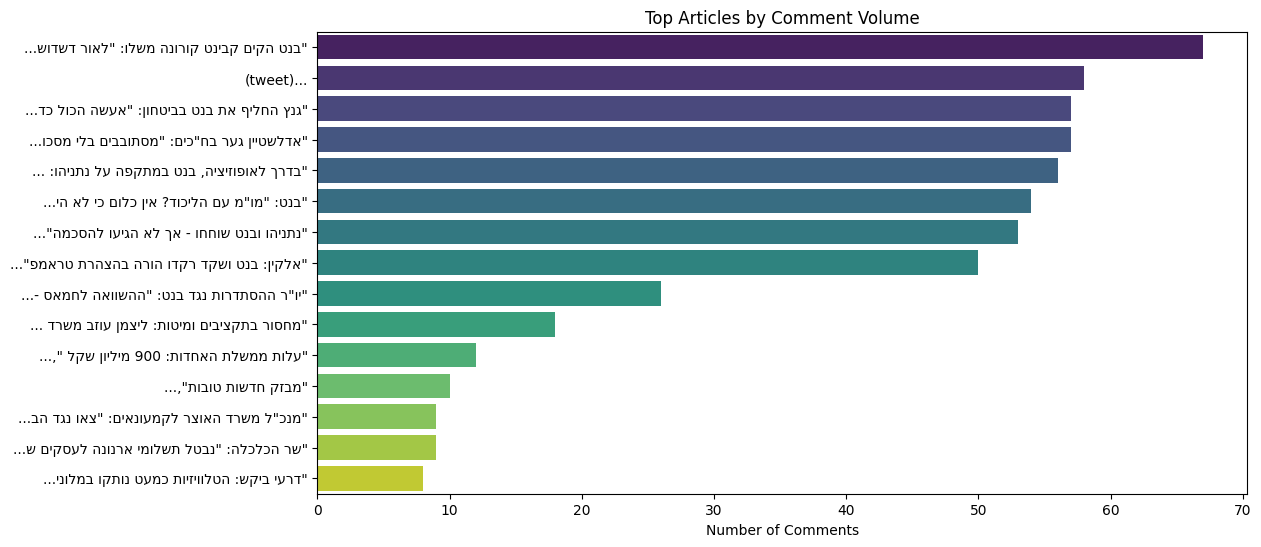


⚠️ מדד ההטיה:
   10 הכתבות הגדולות מהוות 10.6% מכלל הדאטה.
   🟢 מסקנה: הדאטה מגוון יחסית.


In [ ]:
1# התקנת ספרייה לסידור עברית בגרפים (אם צריך)

from bidi.algorithm import get_display

def analyze_topic_diversity(df):
    if df.empty: return

    print("\n📊 --- דו\"ח גיוון נתונים (Diversity Report) ---")

    # 1. כמה כתבות שונות (Articles) יש בדאטה?
    unique_titles = df['title'].nunique()
    total_comments = len(df)
    print(f"מספר הכתבות הייחודיות בדאטה: {unique_titles}")
    print(f"ממוצע תגובות לכתבה: {total_comments / unique_titles:.1f}")

    # 2. הצגת 10 הכתבות ה\"חפורות\" ביותר
    top_titles = df['title'].value_counts().head(15)

    print("\n🏆 10 הכתבות עם הכי הרבה תגובות:")
    for title, count in top_titles.items():
        print(f"   - ({count} תגובות): {title}")

    # 3. ויזואליזציה של ההתפלגות
    plt.figure(figsize=(12, 6))

    # תיקון עברית לגרף
    titles_bidi = [get_display(t[:40] + '...') for t in top_titles.index] # קיצור כותרות ארוכות

    sns.barplot(x=top_titles.values, y=titles_bidi, palette="viridis")
    plt.title("Top Articles by Comment Volume")
    plt.xlabel("Number of Comments")
    plt.show()

    # 4. בדיקת הטיה (Bias Check)
    # נבדוק איזה אחוז מהדאטה תופסות 10 הכתבות הגדולות
    top_10_coverage = top_titles.sum() / total_comments * 100
    print(f"\n⚠️ מדד ההטיה:")
    print(f"   10 הכתבות הגדולות מהוות {top_10_coverage:.1f}% מכלל הדאטה.")

    if top_10_coverage > 50:
        print("   🔴 מסקנה: הדאטה מוטה מאוד למספר מצומצם של אירועים.")
    elif top_10_coverage > 20:
        print("   🟠 מסקנה: יש הטיה מסוימת, אך יש זנב ארוך של כתבות אחרות.")
    else:
        print("   🟢 מסקנה: הדאטה מגוון יחסית.")

# הרצה
analyze_topic_diversity(ugc_df)

In [ ]:
import bz2
import xml.etree.ElementTree as ET
import mwparserfromhell

WIKI_DUMP_PATH = DATA_DIR / "hewiki-latest-pages-articles.xml.bz2"
WIKI_DUMP_URL = "https://dumps.wikimedia.org/hewiki/latest/hewiki-latest-pages-articles.xml.bz2"

# if not WIKI_DUMP_PATH.exists():
print("Downloading Hebrew Wikipedia dump... (יכול לקחת זמן, ~1GB)")
!wget -q -O "$WIKI_DUMP_PATH" "$WIKI_DUMP_URL"
# else:
#     print("Wiki dump כבר קיים, מדלגים על הורדה.")

WIKI_DUMP_PATH


PosixPath('data/hewiki-latest-pages-articles.xml.bz2')

In [ ]:
import requests
from tqdm.auto import tqdm
from pathlib import Path

# וידוא שהתיקייה קיימת (הנחה ש-DATA_DIR מוגדר, אם לא - תגדיר אותו)
# DATA_DIR = Path("./data")
# DATA_DIR.mkdir(exist_ok=True)

WIKI_DUMP_PATH = DATA_DIR / "hewiki-latest-pages-articles.xml.bz2"
WIKI_DUMP_URL = "https://dumps.wikimedia.org/hewiki/latest/hewiki-latest-pages-articles.xml.bz2"

def download_with_tqdm(url, dest_path):
    print(f"📥 מתחיל הורדה: {url}")

    # שליחת בקשה עם stream=True כדי לא לטעון הכל לזיכרון בבת אחת
    response = requests.get(url, stream=True)

    # קבלת הגודל הכולל של הקובץ (בבייטים)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024 * 1024  # גודל כל "בלוק" שיורד (1MB)

    # פתיחת הקובץ לכתיבה בינארית ופתיחת סרגל ההתקדמות
    with open(dest_path, 'wb') as file, tqdm(
        desc="Wiki Dump",
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            size = file.write(data)
            bar.update(size)

    print(f"\n✅ ההורדה הושלמה: {dest_path}")

# --- הרצה ---
if not WIKI_DUMP_PATH.exists():
    download_with_tqdm(WIKI_DUMP_URL, WIKI_DUMP_PATH)
else:
    print("✅ קובץ ה-Dump כבר קיים, מדלגים על הורדה.")

# בדיקה שהקובץ שם
WIKI_DUMP_PATH

In [ ]:
# import requests
# from tqdm.auto import tqdm
# from pathlib import Path

# WIKI_DUMP_PATH = DATA_DIR / "hewiki-latest-pages-articles.xml.bz2"
# WIKI_DUMP_URL = "https://dumps.wikimedia.org/hewiki/latest/hewiki-latest-pages-articles.xml.bz2"

# def download_wiki():
#     response = requests.get(WIKI_DUMP_URL, stream=True)
#     total_size = int(response.headers.get('content-length', 0))

#     print(f"Downloading Hebrew Wikipedia dump... (~{total_size / 1024**2:.1f} MB)")

#     with open(WIKI_DUMP_PATH, "wb") as f, tqdm(
#         desc="Progress",
#         total=total_size,
#         unit='iB',
#         unit_scale=True,
#         unit_divisor=1024,
#     ) as bar:
#         for data in response.iter_content(chunk_size=1024 * 1024): # 1MB chunks
#             size = f.write(data)
#             bar.update(size)

# if not WIKI_DUMP_PATH.exists():
#     download_wiki()
# else:
#     print("Wiki dump כבר קיים, מדלגים על הורדה.")


In [ ]:
# 1. התקנות ואימפורטים (ודא ש-lxml ו-tqdm מותקנים)

import bz2
import os
import pandas as pd
import mwparserfromhell
from lxml import etree
from pathlib import Path
from tqdm.auto import tqdm  # <--- האימפורט החדש

# הגדרות
if 'DATA_DIR' not in globals():
    DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)
MAX_WIKI_ARTICLES = 25_000
MAX_WORDS_PER_DOC = 100
WIKI_DUMP_PATH = "./data/hewiki-latest-pages-articles.xml.bz2"

def process_wikipedia_dump_with_tqdm(dump_path, max_articles=MAX_WIKI_ARTICLES):
    print(f"📚 מעבד את ויקיפדיה (מטרה: {max_articles} ערכים)...")
    wiki_data = []

    # --- הגדרת הבר של tqdm ---
    # total=max_articles: כדי שיידע לחשב אחוזים וזמן סיום
    # unit='doc': שירשום "docs/s"
    with tqdm(total=max_articles, desc="Processing Wiki", unit="doc") as pbar:

        with bz2.open(dump_path, 'rb') as f:
            context = etree.iterparse(f, events=("end",))

            for event, elem in context:
                if elem.tag.endswith('page'):
                    ns_map = elem.nsmap
                    ns = elem.find("ns", namespaces=ns_map) if ns_map else elem.find("ns")
                    if ns is None: ns = elem.find("ns")

                    # בדיקה שזה ערך אנציקלופדי (Namespace 0)
                    if ns is not None and ns.text == '0':
                        try:
                            # חילוץ טקסט
                            text_elem = elem.find("revision/text", namespaces=ns_map)
                            if text_elem is None: text_elem = elem.find(".//text", namespaces=ns_map)

                            if text_elem is not None and text_elem.text:
                                raw_text = text_elem.text
                                parsed = mwparserfromhell.parse(raw_text).strip_code().strip()

                                # חיתוך וסינון
                                words = parsed.split()
                                if len(words) > 30:
                                    truncated = " ".join(words[:MAX_WORDS_PER_DOC])
                                    wiki_data.append(truncated)

                                    # --- עדכון הבר ---
                                    pbar.update(1)
                        except:
                            pass

                    # ניקוי זיכרון (קריטי!)
                    elem.clear()
                    while elem.getprevious() is not None:
                        del elem.getparent()[0]

                    # עצירה כשמגיעים ליעד
                    if len(wiki_data) >= max_articles:
                        break

    print(f"\n✅ ויקיפדיה מוכנה: {len(wiki_data)} ערכים.")
    return pd.DataFrame({'text': wiki_data, 'source': 'wikipedia', 'dominant_emotion': 'wiki_fact'})

# --- הרצה ---
if os.path.exists(WIKI_DUMP_PATH):
    wiki_df = process_wikipedia_dump_with_tqdm(WIKI_DUMP_PATH)
    wiki_df.to_parquet(DATA_DIR / "wiki_25k_truncated.parquet")
else:
    print("⚠️ קובץ ה-Dump לא נמצא. וודא שהורדת אותו.")

📚 מעבד את ויקיפדיה (מטרה: 25000 ערכים)...


Processing Wiki:   0%|          | 0/25000 [00:00<?, ?doc/s]


✅ ויקיפדיה מוכנה: 25000 ערכים.


In [ ]:
# --- תא מלא: עיבוד ויקיפדיה עם tqdm וניקוי חכם ---

# 1. התקנות ואימפורטים

import bz2
import os
import re
import pandas as pd
import mwparserfromhell
from lxml import etree
from pathlib import Path
from tqdm.auto import tqdm

# 2. הגדרות
if 'DATA_DIR' not in globals():
    DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

# נתיב לקובץ ה-Dump (וודא שהוא קיים בתיקייה זו)
WIKI_DUMP_PATH = "./data/hewiki-latest-pages-articles.xml.bz2"

# פרמטרים
MAX_WIKI_ARTICLES = 25_000   # כמות הערכים
MAX_WORDS_PER_DOC = 100      # חיתוך לזיכרון

# 3. פונקציית עזר לניקוי שאריות ויקיפדיה (תמונות, גדלים וכו')
def clean_wiki_artifacts(text):
    if not text: return ""
    # הסרת תבניות תמונה נפוצות כמו "ממוזער|250px|..."
    text = re.sub(r'ממוזער\|\d+px\|.*?(?=\s)', '', text)
    text = re.sub(r'שמאל\|\d+px\|.*?(?=\s)', '', text)
    text = re.sub(r'ימין\|\d+px\|.*?(?=\s)', '', text)
    # הסרת מילים בודדות טכניות שנשארו
    text = text.replace('ממוזער', '').replace('px', '')
    return text.strip()

# 4. הפונקציה הראשית
def process_wikipedia_dump_final(dump_path, max_articles=MAX_WIKI_ARTICLES):
    print(f"📚 מעבד את ויקיפדיה (מטרה: {max_articles} ערכים)...")
    wiki_data = []

    # הגדרת פס ההתקדמות
    with tqdm(total=max_articles, desc="Processing Wiki", unit="doc") as pbar:

        with bz2.open(dump_path, 'rb') as f:
            # שימוש ב-lxml למהירות
            context = etree.iterparse(f, events=("end",))

            for event, elem in context:
                # זיהוי תגית page
                if elem.tag.endswith('page'):
                    # טיפול ב-Namespaces
                    ns_map = elem.nsmap
                    ns = elem.find("ns", namespaces=ns_map) if ns_map else elem.find("ns")
                    if ns is None: ns = elem.find("ns")

                    # רק ערכים אנציקלופדיים (Namespace 0)
                    if ns is not None and ns.text == '0':
                        try:
                            # חילוץ הטקסט
                            text_elem = elem.find("revision/text", namespaces=ns_map)
                            if text_elem is None: text_elem = elem.find(".//text", namespaces=ns_map)

                            if text_elem is not None and text_elem.text:
                                raw_text = text_elem.text
                                # ניקוי קוד ויקי
                                parsed = mwparserfromhell.parse(raw_text).strip_code().strip()
                                # ניקוי שאריות ויזואליות
                                cleaned_text = clean_wiki_artifacts(parsed)

                                # חיתוך ל-100 מילים (דיאטת זיכרון)
                                words = cleaned_text.split()
                                if len(words) > 30: # סינון קצרמרים
                                    truncated = " ".join(words[:MAX_WORDS_PER_DOC])
                                    wiki_data.append(truncated)

                                    # עדכון פס ההתקדמות
                                    pbar.update(1)
                        except Exception as e:
                            pass # דילוג על ערכים בעייתיים

                    # --- ניהול זיכרון קריטי ---
                    elem.clear()
                    while elem.getprevious() is not None:
                        del elem.getparent()[0]

                    # עצירה בהגעה ליעד
                    if len(wiki_data) >= max_articles:
                        break

    print(f"\n✅ ויקיפדיה מוכנה: {len(wiki_data)} ערכים.")
    return pd.DataFrame({
        'text': wiki_data,
        'source': 'wikipedia',
        'dominant_emotion': 'wiki_fact' # תיוג ניטרלי לויקיפדיה
    })

# 5. הרצה ושמירה
if os.path.exists(WIKI_DUMP_PATH):
    wiki_df = process_wikipedia_dump_final(WIKI_DUMP_PATH)

    # שמירה ל-Parquet
    save_path = DATA_DIR / "wiki_25k_truncated.parquet"
    wiki_df.to_parquet(save_path)
    print(f"💾 נשמר לקובץ: {save_path}")

    # הצצה לתוצאה
    print("\nדוגמה לערך מעובד:")
    print(wiki_df['text'].iloc[0][:200] + "...")
else:
    print(f"⚠️ הקובץ {WIKI_DUMP_PATH} לא נמצא. יש להוריד אותו תחילה.")

📚 מעבד את ויקיפדיה (מטרה: 25000 ערכים)...


Processing Wiki:   0%|          | 0/25000 [00:00<?, ?doc/s]

KeyboardInterrupt: 

In [ ]:
for i, text in enumerate(wiki_df["text"].head(5)):
    print(f"--- Text {i+1} ---")
    print(text, "...") # מדפיס רק את ה-200 תווים הראשונים של כל ערך


In [ ]:
save_path

In [ ]:
# --- תא העתקה ל-Drive (חובה להריץ במחברת הראשונה) ---
from google.colab import drive
import shutil
import os
from pathlib import Path

# 1. חיבור לדרייב
print("🔗 מתחבר ל-Google Drive...")
drive.mount('/content/drive')

# 2. הגדרת נתיבים
LOCAL_DIR = Path("./data")  # איפה שהקבצים נמצאים עכשיו אצלך
DRIVE_DIR = Path("/content/drive/MyDrive/HebrewTopicModel/data") # לאן נעתיק אותם

# יצירת התיקייה בדרייב אם לא קיימת
DRIVE_DIR.mkdir(parents=True, exist_ok=True)

# 3. העתקת הקבצים
files_to_move = ["wiki_25k_truncated.parquet", "hebert_raw.parquet"]

print(f"📦 מעתיק קבצים מ-{LOCAL_DIR} ל-{DRIVE_DIR}...")

for filename in files_to_move:
    src = LOCAL_DIR / filename
    dst = DRIVE_DIR / filename

    if src.exists():
        shutil.copy2(src, dst)
        print(f"✅ הועתק בהצלחה: {filename}")
    else:
        print(f"❌ קובץ לא נמצא מקומית: {filename} (האם הרצת את יצירת הדאטה?)")

print("\n🎉 סיימנו. עכשיו אפשר לעבור למחברות הבאות ולטעון מהדרייב.")